## Storage

Azure provide many options for storing data. For cloud-native workflows favored by the Planetary Computer, [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction) is a good choice. In this example we'll compute NDVI for a timeseries of images and write the results to a container in Azure Blob Storage as a single-band COG.

### Compute NDVI

We'll compute the NDVI on a single COG using the Planetary Computer's STAC endpoint.

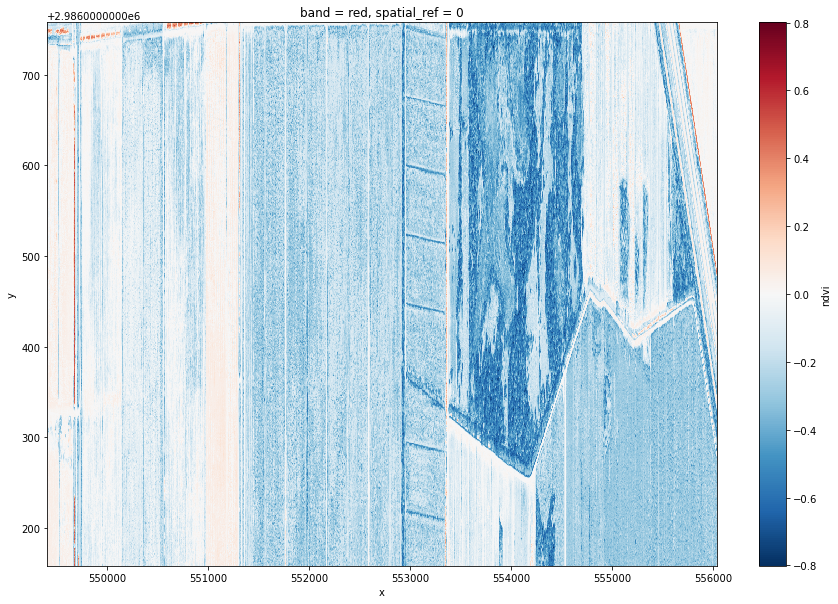

In [1]:
import pystac
import planetary_computer
import rioxarray
import xrspatial

item = pystac.Item.from_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/naip/items/fl_m_2608005_nw_17_060_20191215_20200113"
)
url = planetary_computer.sign(item.assets['image'].href)
ds = (
    rioxarray.open_rasterio(url)[:1000, :1000]
        .assign_coords(band=["red", "green", "blue", "nir"])
        .load()
        .astype(float)
)

ndvi = xrspatial.ndvi(ds.sel(band="red"), ds.sel(band="nir"))
ndvi.plot.imshow(figsize=(15, 10));

### Write to Azure Blob Storage

Now we'll use the `azure.storage.blob` package to write this data to blob storage. See the [quickstart](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-python) for more information.

In this case we'll write to the `pc-scratch` *container* in the `pcstoraccount` *storage account*.  We'll make a [ContainerClient](https://docs.microsoft.com/en-us/python/api/azure-storage-blob/azure.storage.blob.containerclient?view=azure-python) using a connectiong string. This connection string is private, so we'll securely transfer it using `getpass.getpass`.

In [2]:
import rasterio
import getpass
import azure.storage.blob
import tempfile

connection_string = getpass.getpass()
container_client = azure.storage.blob.ContainerClient.from_connection_string(
    connection_string,
    "pc-scratch"
)

 ····························································································································································································


First, we'll write the `ndvi` data to a single-band COG and upload that to Blob Storage..

In [3]:
with tempfile.TemporaryFile() as f:
    ndvi.rio.to_raster(f, driver="COG")
    f.seek(0)
    buffer = f.read()
    blob_client = container_client.get_blob_client("ndvi-wb.tif")
    blob_client.upload_blob(buffer, overwrite=True)

Now the data is available in Azure Blob Storage, so we can read the data. We'll generate a read-only [SAS token](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and attach it to the URL of the blob. This lets tools like `rasterio` and `rioxarray` open the data without having to download it locally.

In [4]:
import urllib.parse

sas_token = azure.storage.blob.generate_blob_sas(
    container_client.account_name,
    container_client.container_name,
    blob_client.blob_name,
    account_key=container_client.credential.account_key,
    permission=["read"]
)
url = blob_client.url + "?" + urllib.parse.quote_plus(sas_token)

rioxarray.open_rasterio(url)

<xarray.DataArray (band: 1, y: 1000, x: 11050)>
[11050000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 2.987e+06 2.987e+06 ... 2.986e+06 2.986e+06
  * x            (x) float64 5.494e+05 5.494e+05 5.494e+05 ... 5.56e+05 5.56e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ndvi
    grid_mapping:  spatial_ref